# Part 2
## Q-learning with Neural Network approximator

![title](imgs/nn_v1.png)

### Forward pass
The feedforward equations are:
\begin{equation}
    \color{blue}q = w_1\color{blue}{x_1} + w_2\color{blue}{x_2} + w_3\color{blue}{x_3} + b = \left[\begin{array}{ccc}w_1&w_2&w_3\end{array}\right]\left[\color{blue}{\begin{array}{c}x_1\\
    x_2\\
    x_3\end{array}}\right] + b = W\color{blue}X + b
\end{equation}
\begin{equation}
    \color{blue}z = f(\color{blue}q) = f(W\color{blue}X + b)
\end{equation}

Consider training the network with mini batches of size $m$, then, the sizes of the diferent matrices become:

\begin{equation}
    \color{blue}X \rightarrow d\times m
\end{equation}
\begin{equation}
    W \rightarrow 1\times d
\end{equation}
\begin{equation}
    \color{blue}q \rightarrow 1\times m
\end{equation}
\begin{equation}
    \color{blue}z \rightarrow 1\times m
\end{equation}

where $d$ denotes the dimension of the input space, which in our example is $d=3$.

### Backward pass
Once the forward pass is complete, we can compute the prediction error as (here we use the MSE as an example):

\begin{equation}
    \color{red}L = \frac{1}{2m}(\hat{z} - \color{blue}z)^2 \rightarrow 1\times m
\end{equation}

where $\hat{z}$ denotes the desired output or target. The gradient of $\color{red}L$ w.r.t $\color{blue}z$ becomes:

\begin{equation}
    \color{red}{\nabla_zL} = -\frac{1}{m}(\hat{z} - \color{blue}z) \rightarrow 1\times m 
\end{equation}

this gradient is the one that is going to be backpropagated. If we denote:

\begin{equation}
    f'(\color{blue}q) = \frac{df(\color{blue}{q})}{dq}\bigg|_{\color{blue}q=W^T\color{blue}X + b} \rightarrow 1\times m
\end{equation}

the gradient of $\color{red}L$ w.r.t $\color{blue}q$ is (here $*$ denotes elementwise multiplication):

\begin{equation}
    \color{red}{\nabla_qL} = f'(\color{blue}q)*\color{red}{\nabla_zL} \rightarrow 1\times m 
\end{equation}

Following the same idea the other backpropagation equations are:

\begin{equation}
    \color{red}{\nabla_{x_1}L} = w_1\color{red}{\nabla_qL} \rightarrow 1\times m 
\end{equation}
\begin{equation}
    \color{red}{\nabla_{x_2}L} = w_2\color{red}{\nabla_qL} \rightarrow 1\times m 
\end{equation}
\begin{equation}
    \color{red}{\nabla_{x_3}L} = w_3\color{red}{\nabla_qL} \rightarrow 1\times m 
\end{equation}

\begin{equation}
    \color{red}{\nabla_{w_1}L} = \color{blue}{x_1}\color{red}{\nabla_qL} \rightarrow 1\times m 
\end{equation}
\begin{equation}
    \color{red}{\nabla_{w_2}L} = \color{blue}{x_2}\color{red}{\nabla_qL} \rightarrow 1\times m 
\end{equation}
\begin{equation}
    \color{red}{\nabla_{w_3}L} = \color{blue}{x_3}\color{red}{\nabla_qL} \rightarrow 1\times m 
\end{equation}
\begin{equation}
    \color{red}{\nabla_bL} = \color{red}{\nabla_qL} \rightarrow 1\times m 
\end{equation}

In matrix form these equations are:

\begin{equation}
    \color{red}{\nabla_XL} = W^T\color{red}{\nabla_qL} \rightarrow d\times m  
\end{equation}

\begin{equation}
    \color{red}{\nabla_WL} = \color{red}{\nabla_qL}\color{blue}X^T \rightarrow 1\times d 
\end{equation}

\begin{equation}
    \color{red}{\nabla_bL} = \sum\color{red}{\nabla_qL} \rightarrow 1\times 1  
\end{equation}

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from envs.environments import grid_world
from utilities import plot_policies
from agents.Qlearning import nn_Qlearning

## Two layers neural network implementation

In [ ]:
class two_layers_nn():
    def __init__(self,input_dim,hidden1_dim,hidden2_dim,output_dim,learning_rate=0.001):
        self._in_dim = input_dim
        self._h1_dim = hidden1_dim
        self._h2_dim = hidden2_dim
        self._out_dim = output_dim
        self._alpha = learning_rate
        self.reset()
        
    def reset(self):
        #Fan in (XAVIER INITIALIZATION)
        fin1 = 1.0/np.sqrt(self._in_dim)
        fin2 = 1.0/np.sqrt(self._h1_dim)
        fin3 = 1.0/np.sqrt(self._h2_dim)

        #Weights
        self._W01 = 2.0*fin1*np.random.random((self._h1_dim,self._in_dim))-fin1    # Shape: (h1 x d)
        self._W12 = 2.0*fin2*np.random.random((self._h2_dim,self._h1_dim))-fin2    # Shape: (h2 x h1)
        self._W23 = 2.0*fin3*np.random.random((self._out_dim,self._h2_dim))-fin3   # Shape: (out x h2)

        #Biases
        self._B1 = 2.0*fin1*np.random.random((self._h1_dim,1))-fin1                # Shape: (h1 x 1)
        self._B2 = 2.0*fin2*np.random.random((self._h2_dim,1))-fin2                # Shape: (h2 x 1)
        self._B3 = 2.0*fin3*np.random.random((self._out_dim,1))-fin3               # Shape: (out x 1)
  
    def ReLU(self,x,deriv=False):
        if not deriv:
            return np.maximum(x,0.0)
        else:
            return np.maximum(np.sign(x),0.0)
        
    def linear(self,x,deriv=False):
        if not deriv:
            return x
        else:
            return 1.0
    
    def forward_pass(self,input_data):
        assert input_data.shape[0]==self._in_dim, "Input must have shape: (in x batch)"        
        self._layer0 = input_data                                           # Shape: (d x m)
        self._layer1 = self.ReLU(np.dot(self._W01,self._layer0)+self._B1)   # Shape: (h1 x m)
        self._layer2 = self.ReLU(np.dot(self._W12,self._layer1)+self._B2)   # Shape: (h2 x m)
        self._layer3 = self.linear(np.dot(self._W23,self._layer2)+self._B3) # Shape: (out x m)
        return self._layer3
    
    def backward_pass(self,target):
        #LOSS
        assert target.shape[0]==self._out_dim, "Target must have shape: (out x batch)"
        batch_size = target.shape[1]
        loss = np.square(target-self._layer3)/(2.0*batch_size)   # Shape: (out x m)
        grad_loss = -(target-self._layer3)/(batch_size)          # Shape: (out x m)

        #LAYER 3
        grad_in_layer3 = grad_loss                                        # Shape: (out x m)
        grad_q_layer3 = self.linear(self._layer3,True)*grad_in_layer3     # Shape: (out x m)
        grad_W23 = np.dot(grad_q_layer3,self._layer2.T)                   # Shape: (out x h2)
        grad_B3 = np.sum(grad_q_layer3,axis=1).reshape(self._out_dim,1)   # Shape: (out x 1)


        #LAYER 2
        grad_in_layer2 = np.dot(self._W23.T,grad_q_layer3)               # Shape: (h2 x m)
        grad_q_layer2 = self.ReLU(self._layer2,True)*grad_in_layer2      # Shape: (h2 x m)
        grad_W12 = np.dot(grad_q_layer2,self._layer1.T)                  # Shape: (h2 x h1)
        grad_B2 = np.sum(grad_q_layer2,axis=1).reshape(self._h2_dim,1)   # Shape: (h1 x 1)


        #LAYER 1
        grad_in_layer1 = np.dot(self._W12.T,grad_q_layer2)               # Shape: (h1 x m)
        grad_q_layer1 = self.ReLU(self._layer1,True)*grad_in_layer1      # Shape: (h1 x m)
        grad_W01 = np.dot(grad_q_layer1,self._layer0.T)                  # Shape: (h1 x d)
        grad_B1 = np.sum(grad_q_layer1,axis=1).reshape(self._h1_dim,1)   # Shape: (h1 x 1)

        
        # Update weights (simple gradient descent)
        self._W01 -= self._alpha*grad_W01
        self._W12 -= self._alpha*grad_W12
        self._W23 -= self._alpha*grad_W23
        self._B1 -= self._alpha*grad_B1
        self._B2 -= self._alpha*grad_B2
        self._B3 -= self._alpha*grad_B3
        
        return loss
        
        

### Overfitting on toy data (to test NN implementation)

In [ ]:
np.random.seed(0)
X = np.array([[0,0,1],[0,1,1],[1,0,1],[1,1,1],[1,0,0]]).T
Y = np.array([[1],[3],[5],[7],[4]]).T
nn = two_layers_nn(3,20,20,1,learning_rate=0.1)
Ntrain = 1000
for iteration in range(Ntrain+1):
    nn.forward_pass(X)
    loss = nn.backward_pass(Y)
    if(iteration%(Ntrain/10)== 0):
        print('It. ',iteration,' Loss: ',np.mean(loss))

predicted = nn.forward_pass(X)
print('Predicted: ',np.round(predicted,3)[0])
print('Correct: ',Y[0])

# Q-learning in the gridworld environment with NN approximator

In [ ]:
def run_training(env,agent,max_episodes,max_steps):
    np.random.seed(123) # Fixed random seed
    for episode in range(max_episodes+1):
        env.reset(random_initial=True)
        state = np.array(env.observe_coordinates()).reshape(2,1)
        done = False
        step = 1
        while (not done and step <= max_steps):
            action = agent.epsilon_greedy(state)
            _,reward,done = env.step(action)
            next_state = np.array(env.observe_coordinates()).reshape(2,1)
            agent.train(state,action,next_state,reward,done)
            state = next_state
            step += 1
        agent.epsilon_decay(rate=0.99)
        if(episode%(max_episodes/10)==0):
            print('Episode: ',episode,' Steps: ',step,' Exploration: ',np.round(agent._epsilon,2))

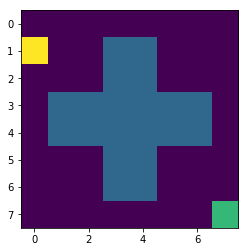

In [3]:
env = grid_world()
#plt.ion()
for ep in range(100):
    action = np.random.randint(0,4)
    env.step(action)
    map = env.render()
    plt.imshow(map)




